# Delta-hedging

## Install needed packages to the Jupyter notebook kernel environment
Uncomment the lines to install. Only needed to run once per kernel/environment.

In [1]:
# %pip install pyfinance
# %pip install py_vollib
# %pip install pandas
# %pip install matplotlib

## Import needed libraries

In [2]:
import pandas as pd
from pyfinance.options import BSM
from datetime import datetime, timedelta
import py_vollib
from py_vollib.black_scholes.implied_volatility import implied_volatility
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.pyplot as plt

## Data wrangling
Here we read the .csv file containing the Apple stock option data, and do a little bit of other data wrangling. First we transform the option data, then the interet rate data and merge the two dataframes.

In [3]:
df = pd.read_csv("../data/apple.csv")
df = df.drop(["Unnamed: 0"], axis=1)
df['date'] = pd.to_datetime(df['Date'])
df['T'] = (pd.to_datetime('2024-01-19') - df['date']).dt.days / 252 # T = time to expiration in years, 252 trading days
df = df.drop(["date"], axis=1)
df.head()

#interest rate data
df2 = pd.read_csv('../data/daily-treasury-rates.csv')
df2 = df2[['Date', '13 WEEKS COUPON EQUIVALENT']]
df2['Date'] = pd.to_datetime(df2['Date'], format='%m/%d/%Y')
df2['Date'] = df2['Date'].dt.strftime('%Y-%m-%d')
df2 = df2[df2['Date'] >= '2023-08-21']
df2['13 WEEKS COUPON EQUIVALENT'] = df2['13 WEEKS COUPON EQUIVALENT'] / 100
df_result = pd.merge(df, df2, on='Date', how='left')
df_result.rename({"13 WEEKS COUPON EQUIVALENT": "Interest rate"}, axis="columns", inplace=True)
df_result['Interest rate'].fillna(df_result['Interest rate'].median(), inplace=True)
df_result.head()

,Date,Underlying,C170,C175,C180,C185,C190,P170,P175,P180,P185,P190,T,Interest rate
0,2023-08-21,175.84,16.40,13.27,10.30,7.85,5.91,6.81,8.65,10.85,13.35,16.50,0.599206,0.0546
1,2023-08-22,177.23,17.50,14.10,11.10,8.51,6.34,6.26,8.10,10.10,12.75,15.50,0.595238,0.0546
2,2023-08-23,181.12,20.20,16.65,13.45,10.55,8.08,5.25,6.71,8.50,10.70,13.33,0.591270,0.0546
3,2023-08-24,176.38,16.97,13.75,10.80,8.35,6.25,6.85,8.62,10.75,13.35,16.60,0.587302,0.0547
4,2023-08-25,178.61,18.50,15.15,11.85,9.19,6.90,5.90,7.50,9.50,11.90,14.81,0.583333,0.0550


The delta measures the rate of change of the security wrt. to the price of the underlying. Thus, the delta of the stock is one.
Vega measures the rate of change of the security wrt. to the volatility of the underlying. Again, the vega of the stock is one. In delta hedging, we short the option and hold a dynamically adjusted amount of the risky asset to eliminate the risk.

Next, calculate the hedge with 2 portfolios: OP and RE. OP has a long call and RE has a short amount of the underlying asset (here, $AAPL). We want P = OP + RE to be neutral to small changes in the underlying price.

# Delta hedging a single option

In [4]:
# The code below is bit of spaghetti code and could use some significant improvements when time available
# Parameters:
# option_prices is a Pandas dataframe consisting of option prices for both calls and puts
# freq is hedging frequency (e.g. 30 = once a month)
# colname is e.g. "C170"
# costs = trading costs
def delta_hedge(option_prices, freq, colname, costs = 0):
    # This has been looked up from the internet for Apple stock option
    # Options are contracts, which are usually sold in amounts of 100 or 1000, depending on the underlying and everything
    # All of the above is initial stuff when time, t = 0
    option_amount = 1000
    interest_rate = option_prices.iloc[0]['Interest rate']
    option_type = 'call' if colname[0] == "C" else "put"
    stock_price = option_prices.iloc[0]['Underlying']
    option_price = option_prices.iloc[0][colname]
    strike = int(colname[1:])
    time_to_maturity = option_prices.iloc[0]['T']
    volatility = implied_volatility(price=option_price, S=stock_price, K=strike, t=time_to_maturity, r=interest_rate, flag=option_type[0])
    
    bsm_obj = BSM(kind=option_type, S0=stock_price, K=strike, T=time_to_maturity, r=interest_rate, sigma=volatility)
    # Value of the option according to BSM from the assignment
    OP = bsm_obj.value() * option_amount
    delta = bsm_obj.delta()
    # Replicating portfolio from the assignment
    RE = - delta * stock_price * option_amount

    # We will keep track of the changes in the portfolios
    total_mean_squared_error = []
    
    # add initial portfolio value to the list
    portfolio_values = [OP+RE]

    # we save these for plotting purposes, not used in this function
    OPs = [OP]
    REs = [RE]
    
    # total transaction costs carry and decrease the value of portfolio
    transact_costs = 0
    
    # next we calculate changes in OP and RE and let A_0 = d OP - d RE
    # Hedge as long as there are dates in the dataframe
    for i in range(1, len(option_prices)-1):
        new_OP = option_prices[colname][i] * option_amount
        new_RE = - delta * option_prices['Underlying'][i] * option_amount
        d_OP = new_OP - OP
        d_RE = new_RE - RE

        # We would want this to be 0 = immune to changes
        a_0 = d_OP + d_RE
        total_mean_squared_error.append(a_0**2)
        portfolio_values.append(OP+RE+transact_costs)
        OPs.append(new_OP)
        REs.append(new_RE)
        
        OP = new_OP
        RE = new_RE

        # Rehedging happens here
        # Change the modulo for different intervals, 1 = every day, 30 = every month and so on
        # Delta and volatility will be updated when we rehedge
        # As time goes by, the stock price moves/changes. This will affect the delta of the stock option, delta of the underlying is always 1
        # In a real world scenario this hedging costs money
        if i % freq == 0:
            delta = BSM(kind=option_type, S0=option_prices['Underlying'][i], K=strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=volatility).delta()
            volatility = BSM(kind=option_type, S0=option_prices['Underlying'][i], K=strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=volatility).implied_vol(option_prices[colname][i])
            
            # We have to solve a linear equation, where the delta of the portfolio is zero
            # TODO: Add the linear equation version
            # And we have to readjust by shorting delta amount of the underlying
            # Delta of the underlying is always 1
            RE = -(delta * option_prices['Underlying'][i] * option_amount)
            # or just the amount
            amount = -(delta * option_amount)

            if amount > 0:
                print('\n Readjusting replicating portoflio RE, amount options to buy to balance the portfolio: ', round(amount))
                # Include trading costs in portfolio value
                transact_costs -= costs * 100000
            elif amount < 0:
                print('Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio: ', round(-amount))
                # Include trading costs in portfolio value
                transact_costs -= costs * 100000
            else:
                print('Portfolio is in balance, no need for readjustment \n')
    
    # Sum 1 to n-1 of the MSEs
    total_error = sum(total_mean_squared_error) - total_mean_squared_error[-1]
    total_error *= (1 / (len(total_mean_squared_error) - 1))
    print("The total mean squared error is : ", total_error)
    print("\n")

    # return daily errors and the total error for plotting purposes
    return total_mean_squared_error, total_error, portfolio_values, OPs, REs
    

Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  723
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  768
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  711
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  735
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  755
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  803
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  849
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  863
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  869
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  884
Readjusting replicat

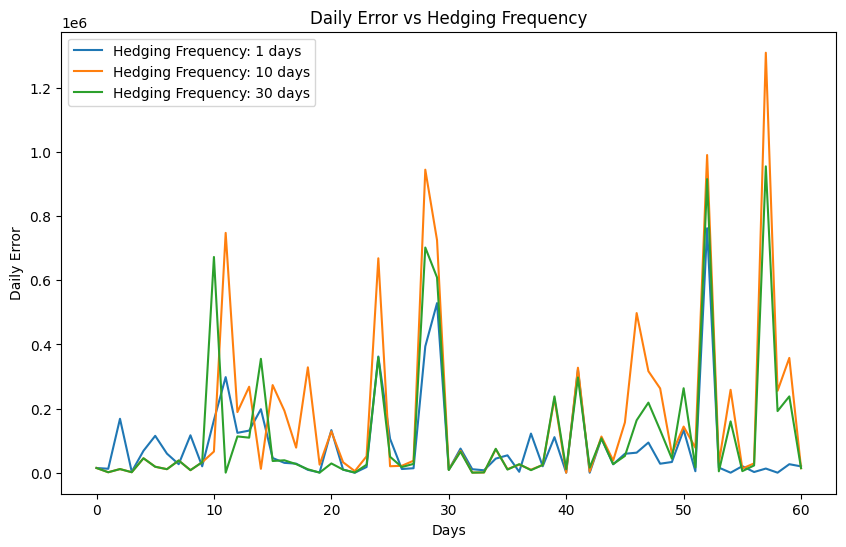

In [5]:
hedging_frequencies = [1, 10, 30]
plt.figure(figsize=(10, 6))
for freq in hedging_frequencies:
    total_mean_squared_error, total_error, portfolio_values, OPs, REs = delta_hedge(df_result, freq, "C170")
    plt.plot(total_mean_squared_error, label=f'Hedging Frequency: {freq} days')

plt.xlabel('Days')
plt.ylabel('Daily Error')
plt.title('Daily Error vs Hedging Frequency')
plt.legend()
plt.show()

Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  723
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  768
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  711
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  735
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  755
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  803
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  849
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  863
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  869
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  884
Readjusting replicat

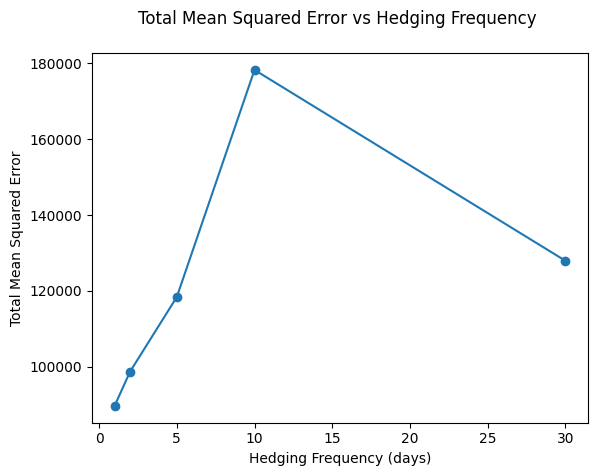

In [6]:
hedging_frequencies = [1, 2, 5, 10, 30]

results_dict = {'Frequency': [], 'Total_MSE': []}

for freq in hedging_frequencies:
    total_mean_squared_error, total_error, portfolio_values, OPs, REs = delta_hedge(df_result, freq, "C170")
    results_dict['Frequency'].append(freq)
    results_dict['Total_MSE'].append(total_error)

# Plotting
plt.plot(results_dict['Frequency'], results_dict['Total_MSE'], marker='o')
plt.xlabel('Hedging Frequency (days)')
plt.ylabel('Total Mean Squared Error')
plt.title('Total Mean Squared Error vs Hedging Frequency \n')
plt.show()

Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  771
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  741
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  800
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  852
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  873
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  734
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  747
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  682
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  698
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  759
Readjusting replicat

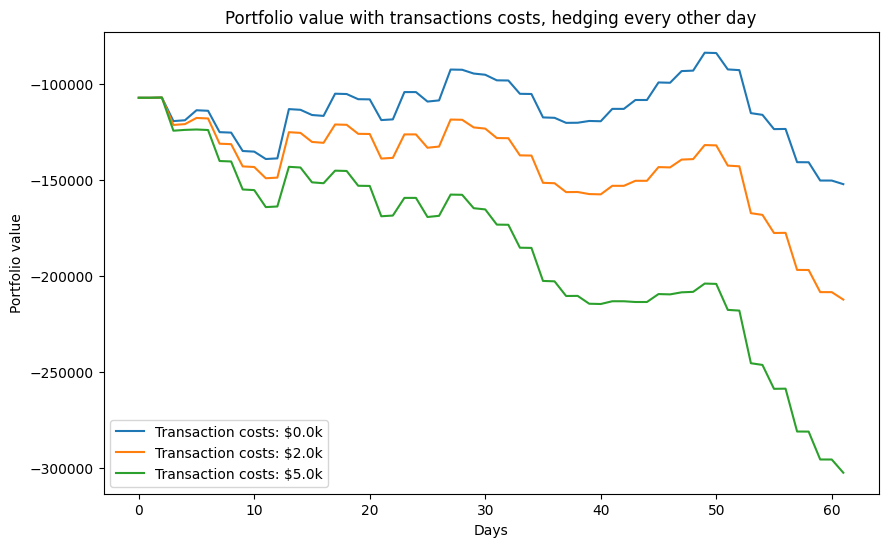

In [7]:
# NOTE: not ready. The costs dont work as percents yet; they are simply 100 000 * cost
# for illustrative purposes. This corresponds to fixed costs, e.g. 100€ per trade.
# These costs mean fixed costs of 0€, 2000€ and 5000€ per trade.

costs = [0.00, 0.02, 0.05]
plt.figure(figsize=(10, 6))
for c in costs:
    total_mean_squared_error, total_error, portfolio_values, OPs, REs = delta_hedge(df_result, 2, "C170", costs=c) #every other day
    plt.plot(portfolio_values, label=f'Transaction costs: ${c*100}k') # change to % once done

plt.xlabel('Days')
plt.ylabel('Portfolio value')
plt.title('Portfolio value with transactions costs, hedging every other day')
plt.legend()
plt.show()


Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  723
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  768
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  711
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  735
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  755
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  803
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  849
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  863
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  869
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  884
Readjusting replicat

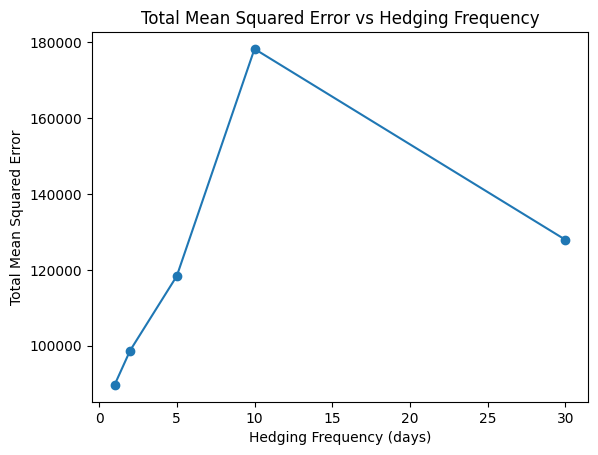

In [8]:
hedging_frequencies = [1, 2, 5, 10, 30]

results_dict = {'Frequency': [], 'Total_MSE': []}

for freq in hedging_frequencies:
    total_mean_squared_error, total_error, portfolio_values, OPs, REs = delta_hedge(df_result, freq, "C170")
    results_dict['Frequency'].append(freq)
    results_dict['Total_MSE'].append(total_error)

# Plotting
plt.plot(results_dict['Frequency'], results_dict['Total_MSE'], marker='o')
plt.xlabel('Hedging Frequency (days)')
plt.ylabel('Total Mean Squared Error')
plt.title('Total Mean Squared Error vs Hedging Frequency')
plt.show()

Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  723
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  768
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  711
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  735
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  755
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  803
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  849
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  863
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  869
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  884
Readjusting replicat

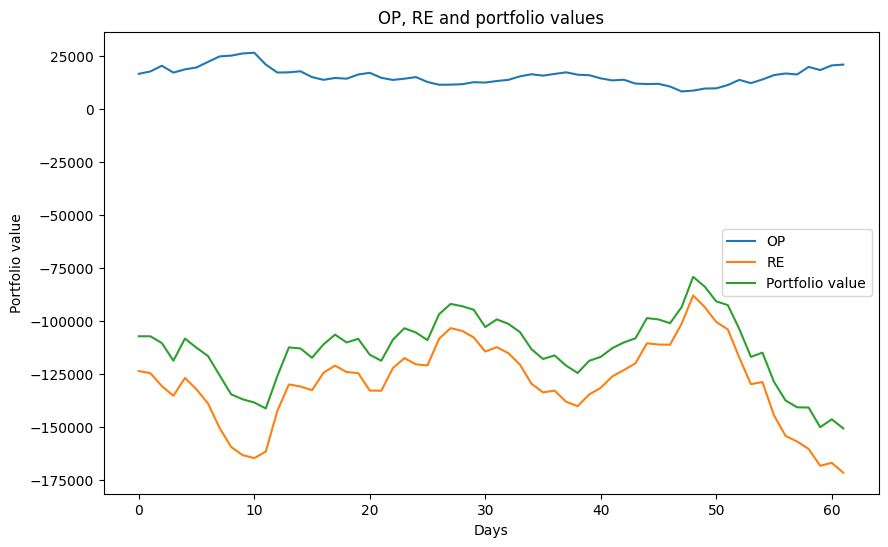

Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  771
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  741
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  800
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  852
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  873
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  734
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  747
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  682
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  698
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  759
Readjusting replicat

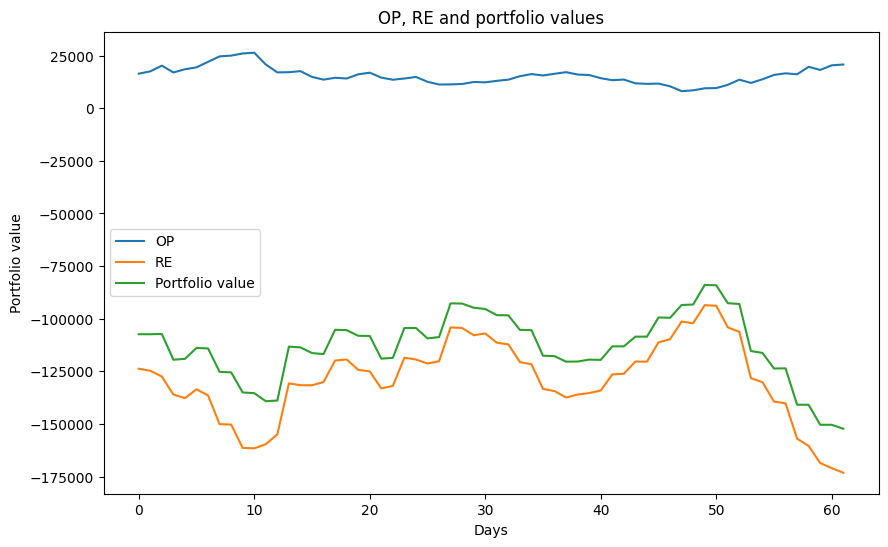

Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  761
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  859
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  716
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  767
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  643
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  638
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  734
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  726
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  659
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  599
Readjusting replicat

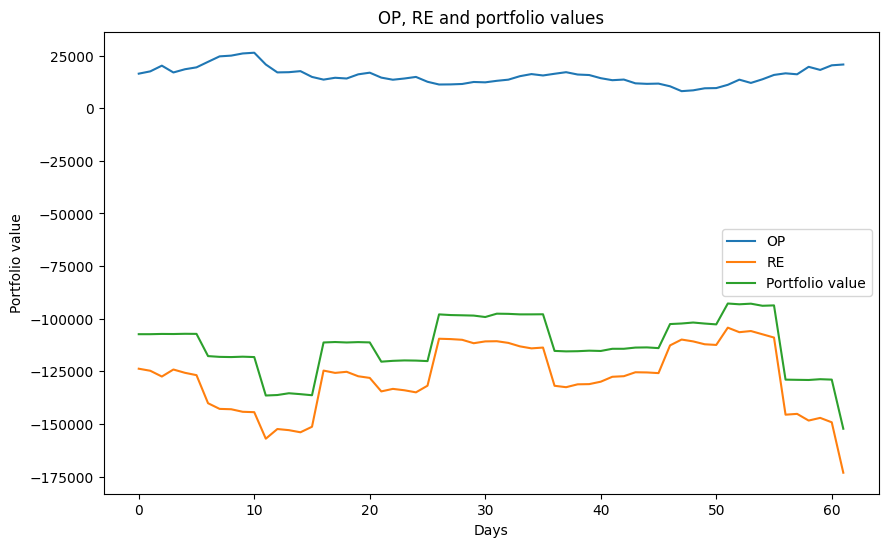

Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  863
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  757
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  649
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  716
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  603
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  875
The total mean squared error is :  178280.72900899392




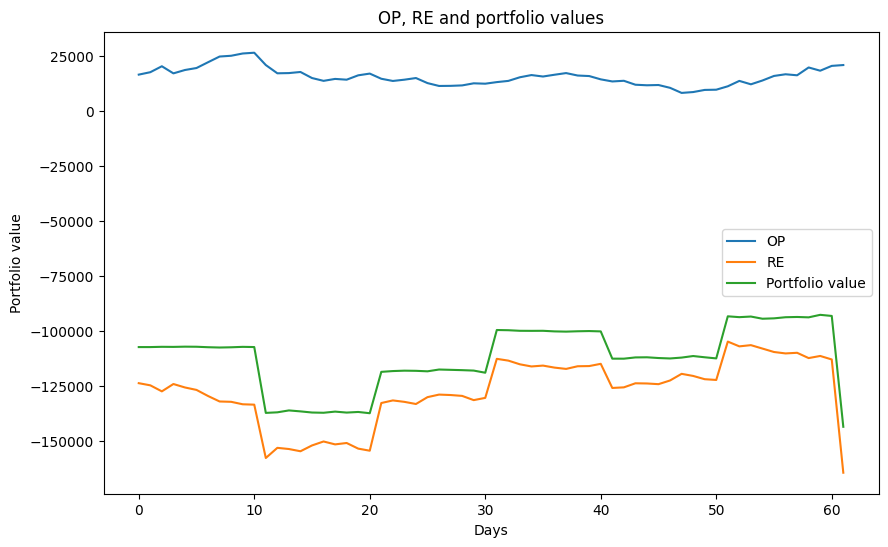

Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  645
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  876
The total mean squared error is :  127941.97425342619




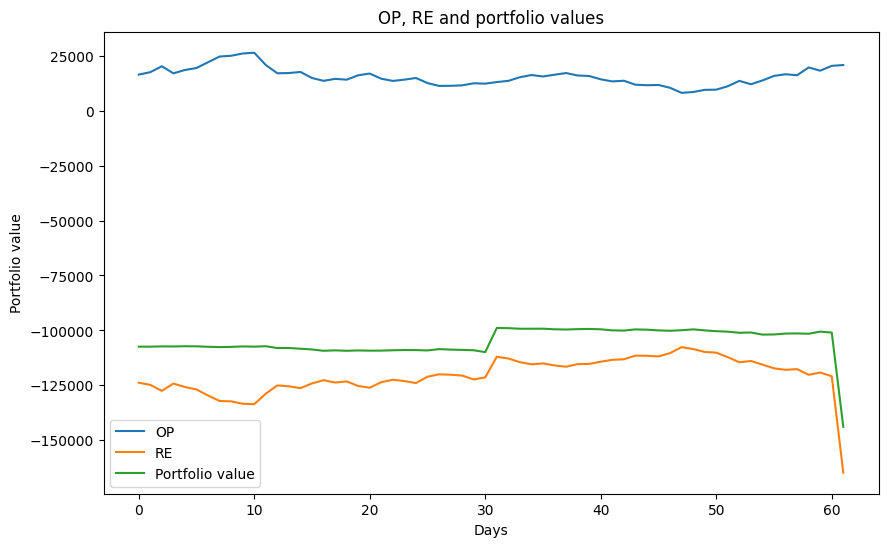

In [9]:
hedging_frequencies = [1, 2, 5, 10, 30]

for freq in hedging_frequencies:
    plt.figure(figsize=(10, 6))
    total_mean_squared_error, total_error, portfolio_values, OPs, REs = delta_hedge(df_result, freq, "C170")
    plt.plot(OPs, label=f'OP')
    plt.plot(REs, label=f'RE')
    plt.plot(portfolio_values, label=f'Portfolio value')
    
    plt.xlabel('Days')
    plt.ylabel('Portfolio value')
    plt.title('OP, RE and portfolio values')
    plt.legend()
    plt.show()

# Delta hedging Straddle option strategy

A Straddle is a combination option trading strategy. Straddle consists of 1 call option and 1 put option, with the same strike price and maturity of the same underlying stock. The idea of making profit using Straddle is that the investor expects the underlying to go to a sharp direction, either up or down.

In [10]:
# TODO: Copy-paste spaghetti, should be refactored when time
def delta_hedge_straddle(option_prices, freq):
    # Apple stock is sold in 1000 pcs units
    # Lets assume that the amount is same for put and call options
    # Not sure if they can be different, like 800 puts and 1000 calls, but could be
    option_amount = 1000
    
    # Initial stuff at t = 0
    # 3-Month Treasury Yield taken on a daily basis regarding our hedging interval
    interest_rate = option_prices.iloc[0]['Interest rate'] 
    stock_price = option_prices.iloc[0]['Underlying']

    # Adjust here the call and put prices for your liking
    # STRADDLE = Same option with same strikes and maturity, put both call and put options
    call_option_price = option_prices.iloc[0]['C180']
    put_option_price = option_prices.iloc[0]['P180']
    strike = 180
    
    time_to_maturity = option_prices.iloc[0]['T']
    call_volatility = implied_volatility(price=call_option_price, S=stock_price, K=strike, t=time_to_maturity, r=interest_rate, flag='c')
    put_volatility = implied_volatility(price=put_option_price, S=stock_price, K=strike, t=time_to_maturity, r=interest_rate, flag='p')
    
    call_bsm = BSM(kind='call', S0=stock_price, K=strike, T=time_to_maturity, r=interest_rate, sigma=call_volatility)
    put_bsm = BSM(kind='put', S0=stock_price, K=strike, T=time_to_maturity, r=interest_rate, sigma=put_volatility)

    # Forming the straddle portfolio
    put_delta = put_bsm.delta()
    call_delta = call_bsm.delta()

    # Long position consists of both of the option values
    OP = call_bsm.value() * option_amount + put_bsm.value() * option_amount

    # Short position, the replicating portfolio, consists of the call and put delta amounts of the underlying 
    RE = - (call_delta * stock_price * option_amount + put_delta * stock_price * option_amount)

    # Combined delta of the options
    combined_delta = call_delta + put_delta

    # Keep track of the mean squared error values, which means changes in the portfolios
    total_mean_squared_error = []
    
    # total transaction costs carry and decrease the value of portfolio
    transact_costs = 0
    
    # add initial portfolio value to the list
    portfolio_values = [OP+RE]

    # we save these for plotting purposes, not used in this function
    OPs = [OP]
    REs = [RE]
    
    # Next we calculate changes in OP and RE and let A_0 = d OP + d RE
    # Hedge as long as there are dates in the dataframe
    for i in range(1, len(option_prices)-1):
        new_call_bsm_obj = BSM(kind='call', S0=option_prices['Underlying'][i], K=strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=call_volatility)
        new_put_bsm_obj = BSM(kind='put', S0=option_prices['Underlying'][i], K=strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=put_volatility)
        new_OP = new_call_bsm_obj.value() * option_amount + new_put_bsm_obj.value() * option_amount
        new_RE = -combined_delta * option_prices['Underlying'][i] * option_amount
        d_OP = new_OP - OP
        d_RE = new_RE - RE
        a_0 = d_OP + d_RE
        total_mean_squared_error.append(a_0**2)
        portfolio_values.append(OP+RE+transact_costs)
        OPs.append(new_OP)
        REs.append(new_RE)
        OP = new_OP
        RE = new_RE

        # Change the modulo for different intervals, 1 = every day, 30 = every month and so on
        # Delta and volatility will be updated when we rehedge
        # As time goes by, the stock price moves/changes. This will affect the delta of the stock option, delta of the underlying is always 1
        # In a real world scenario this hedging costs money, and will be simulated if we have time also in this
        if i % freq == 0:
            put_delta = new_put_bsm_obj.delta()
            call_delta= new_call_bsm_obj.delta()
            combined_delta =  put_delta + call_delta
            call_volatility = BSM(kind='call', S0=option_prices['Underlying'][i], K=strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=call_volatility).implied_vol(option_prices['C180'][i])
            put_volatility = BSM(kind='put', S0=option_prices['Underlying'][i], K=strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=put_volatility).implied_vol(option_prices['P180'][i])

            # We have to solve a linear equation, where the delta of the portfolio is zero
            # TODO: Add the linear equation
            # And we have to readjust by shorting delta amount of the underlying
            # Delta of the underlying is always 1
            RE = -combined_delta * option_prices['Underlying'][i] * option_amount
            
            # Option_amount is the amount of options
            amount = -(combined_delta * option_amount)
            if amount > 0:
                print('Readjusting replicating portoflio RE, amount options to buy to balance the portfolio: ', round(amount))
            elif amount < 0:
                print('Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio: ', round(-amount))
            else:
                print('Portfolio is in balance, no need for readjustment')

    # Sum 1 to n-1 of the MSEs
    total_error = sum(total_mean_squared_error) - total_mean_squared_error[-1]
    total_error *= (1 / (len(total_mean_squared_error) - 1))
    print("The total mean squared error is : ", total_error)
    print("\n")
    
    # return daily errors and the total error for plotting purposes
    return total_mean_squared_error, total_error, portfolio_values, OPs, REs

Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  150
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  262
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  123
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  187
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  232
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  344
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  438
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  449
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  486
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  500
Readjusting replicat

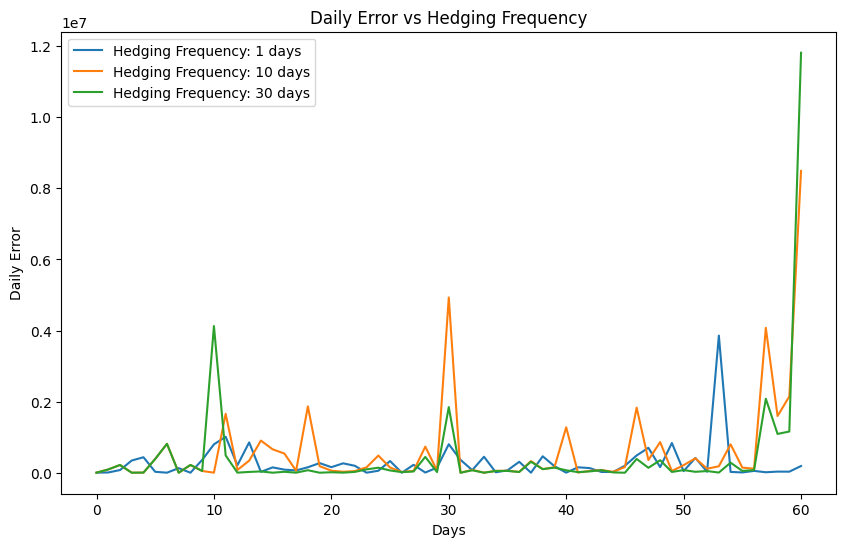

In [12]:
hedging_frequencies = [1, 10, 30]
plt.figure(figsize=(10, 6))
for freq in hedging_frequencies:
    total_mean_squared_error, total_error, portfolio_values, OPs, REs = delta_hedge_straddle(df_result, freq)
    plt.plot(total_mean_squared_error, label=f'Hedging Frequency: {freq} days')

plt.xlabel('Days')
plt.ylabel('Daily Error')
plt.title('Daily Error vs Hedging Frequency')
plt.legend()
plt.show()


Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  150
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  262
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  123
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  187
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  232
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  344
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  438
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  449
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  486
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  500
Readjusting replicat

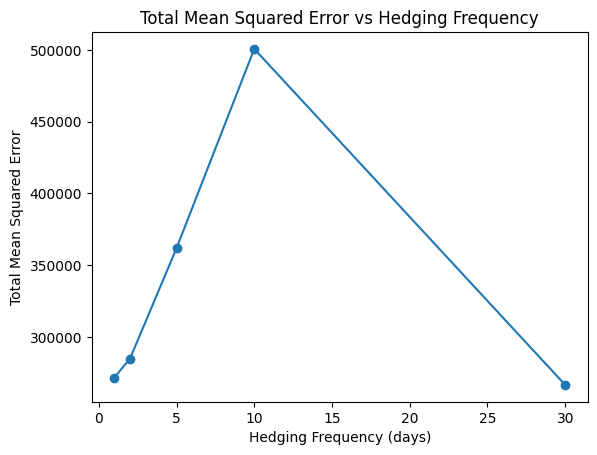

In [13]:
hedging_frequencies = [1, 2, 5, 10, 30]
results_dict = {'Frequency': [], 'Total_MSE': []}

for freq in hedging_frequencies:
    total_mean_squared_error, total_error, portfolio_values, OPs, REs = delta_hedge_straddle(df_result, freq)
    results_dict['Frequency'].append(freq)
    results_dict['Total_MSE'].append(total_error)

plt.plot(results_dict['Frequency'], results_dict['Total_MSE'], marker='o')
plt.xlabel('Hedging Frequency (days)')
plt.ylabel('Total Mean Squared Error')
plt.title('Total Mean Squared Error vs Hedging Frequency')
plt.show()

Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  150
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  262
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  123
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  187
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  232
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  344
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  438
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  449
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  486
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  500
Readjusting replicat

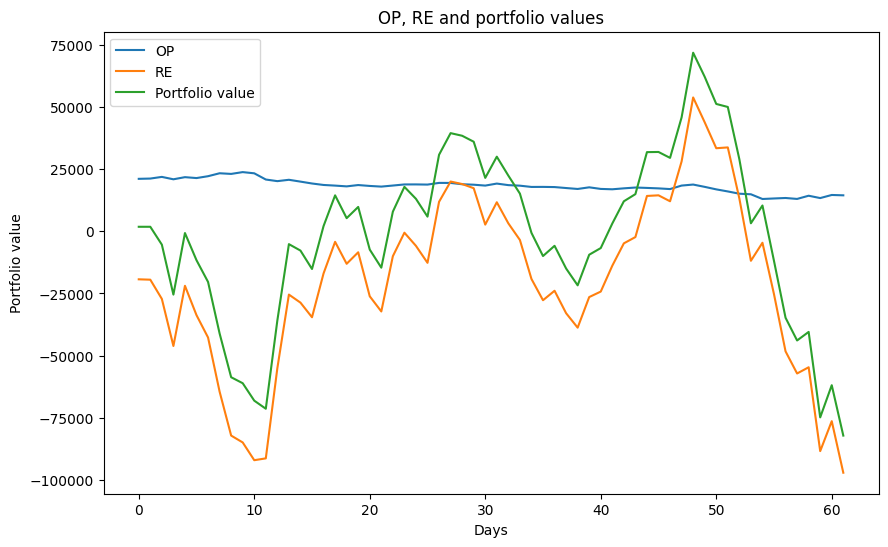

Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  262
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  189
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  341
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  443
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  493
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  144
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  193
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  26
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  48
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  182
Readjusting replicatin

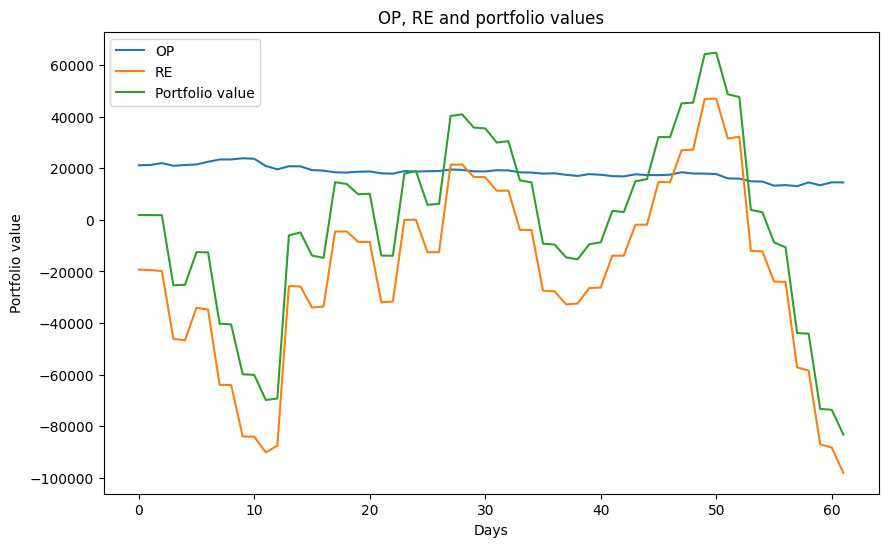

Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  233
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  486
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  97
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  182
Readjusting replicating portoflio RE, amount options to buy to balance the portfolio:  82
Readjusting replicating portoflio RE, amount options to buy to balance the portfolio:  63
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  132
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  79
Readjusting replicating portoflio RE, amount options to buy to balance the portfolio:  79
Readjusting replicating portoflio RE, amount options to buy to balance the portfolio:  200
Readjusting replicating portoflio RE, amount options 

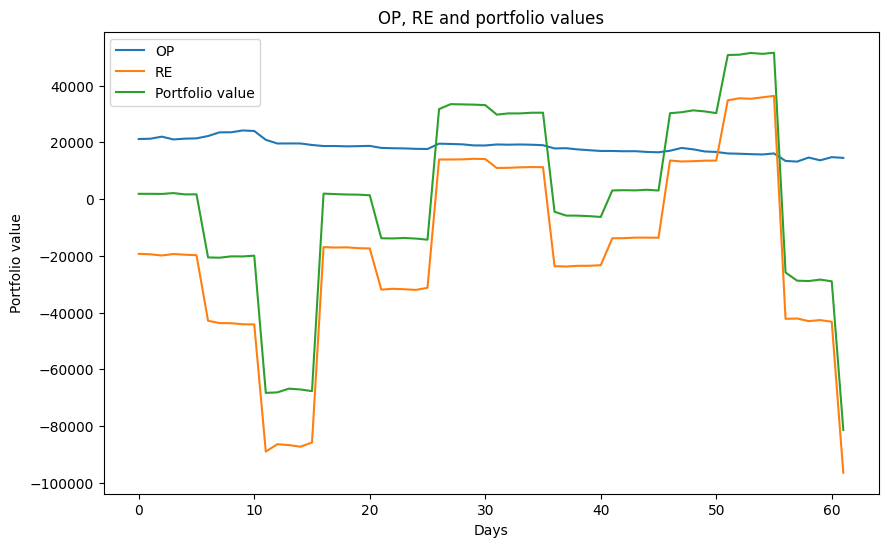

Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  483
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  181
Readjusting replicating portoflio RE, amount options to buy to balance the portfolio:  80
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  80
Readjusting replicating portoflio RE, amount options to buy to balance the portfolio:  207
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  440
The total mean squared error is :  500676.8831194958




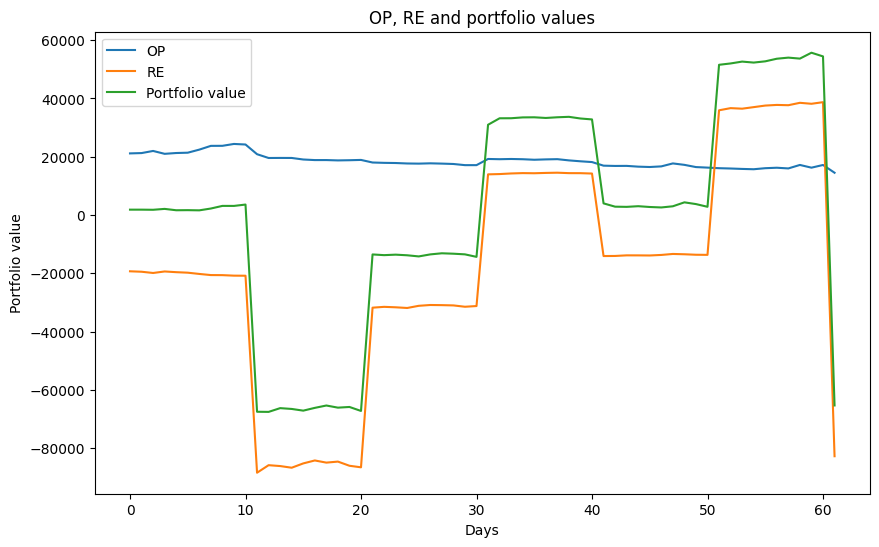

Readjusting replicating portoflio RE, amount options to buy to balance the portfolio:  72
Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio:  428
The total mean squared error is :  266509.6714749044




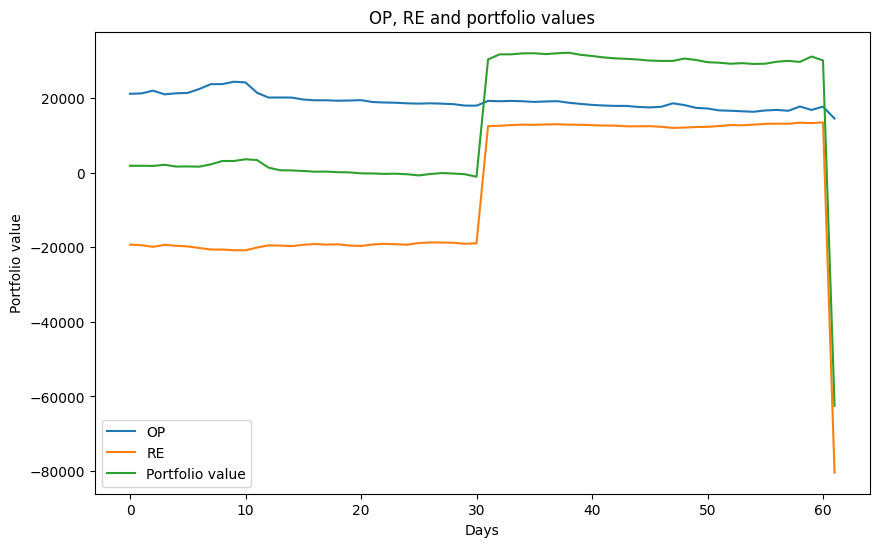

In [15]:
hedging_frequencies = [1, 2, 5, 10, 30]

for freq in hedging_frequencies:
    plt.figure(figsize=(10, 6))
    total_mean_squared_error, total_error, portfolio_values, OPs, REs = delta_hedge_straddle(df_result, freq)
    plt.plot(OPs, label=f'OP')
    plt.plot(REs, label=f'RE')
    plt.plot(portfolio_values, label=f'Portfolio value')
    
    plt.xlabel('Days')
    plt.ylabel('Portfolio value')
    plt.title('OP, RE and portfolio values')
    plt.legend()
    plt.show()

# Delta hedging Strangle option strategy

Strangle is another option strategy, which involves purchasing or selling two options of the same underlying. In Strangle an investor buys a put and a call of the same underlying with the same maturities, but this time the strike prices will be different. The way to make profit is the same as in Straddle, that the investor expects the market to be volatile and move sharp to some direction, either up or down. The difference to Straddle is that the stock price has to move farther in Strangle to make profit.

In our long strangle, we buy an Out-of-The-Money, OTM call and an OTM put.

In [ ]:
# TODO: Copy-paste spaghetti, refactor when time
def delta_hedge_strangle(option_prices, freq):
    # Apple stock is sold in 1000 pcs units
    # Lets assume that the amount is same for put and call options
    # Not sure if they can be different, like 800 puts and 1000 calls, probably
    option_amount = 1000
    
    # Initial stuff at t = 0
    # 3-Month Treasury Yield taken on a daily basis regarding our hedging interval
    interest_rate = option_prices.iloc[0]['Interest rate']
    stock_price = option_prices.iloc[0]['Underlying']

    # Adjust here the call and put prices for your liking
    # STRANGLE = Same option, same maturities, but both call and put which have different strikes
    call_option_price = option_prices.iloc[0]['C180']
    put_option_price = option_prices.iloc[0]['P175']
    put_strike = 175
    call_strike = 180
    
    time_to_maturity = option_prices.iloc[0]['T']
    call_volatility = implied_volatility(price=call_option_price, S=stock_price, K=call_strike, t=time_to_maturity, r=interest_rate, flag='c')
    put_volatility = implied_volatility(price=put_option_price, S=stock_price, K=put_strike, t=time_to_maturity, r=interest_rate, flag='p')
    
    call_bsm = BSM(kind='call', S0=stock_price, K=call_strike, T=time_to_maturity, r=interest_rate, sigma=call_volatility)
    put_bsm = BSM(kind='put', S0=stock_price, K=put_strike, T=time_to_maturity, r=interest_rate, sigma=put_volatility)

    # Forming the straddle portfolio
    put_delta = put_bsm.delta()
    call_delta = call_bsm.delta()

    # Long position consists of both of the option values
    OP = call_bsm.value() * option_amount + put_bsm.value() * option_amount

    # Short position, the replicating protfolio, consists of the call and put delta amounts of the underlying 
    RE = - call_delta * stock_price * option_amount + put_delta * stock_price * option_amount

    # Combined delta of the options
    combined_delta = call_delta + put_delta

    # Keep track of the mean squared error values, which means changes in the portfolios
    # Keep track of the mean squared error values, which means changes in the portfolios
    total_mean_squared_error = []
    
    # Next we calculate changes in OP and RE and let A_0 = d OP - d RE
    # Hedge as long as there are dates in the dataframe
    for i in range(1, len(option_prices)-1):
        new_call_bsm_obj = BSM(kind='call', S0=option_prices['Underlying'][i], K=call_strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=call_volatility)
        new_put_bsm_obj = BSM(kind='put', S0=option_prices['Underlying'][i], K=put_strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=put_volatility)
        new_OP = new_call_bsm_obj.value() * option_amount + new_put_bsm_obj.value() * option_amount
        new_RE = -combined_delta * option_prices['Underlying'][i] * option_amount
        d_OP = new_OP - OP
        d_RE = combined_delta * (option_prices['Underlying'][i+1] - option_prices['Underlying'][i]) * option_amount
        a_0 = d_OP - d_RE
        total_mean_squared_error.append(a_0**2)

        OP = new_OP
        RE = new_RE

        # Rehedging happens here
        # every second day, t2, t4, t6, so on..
        # Change the modulo for different intervals, 1 = every day, 30 = every month and so on
        # Delta and volatility will be updated when we rehedge
        # As time goes by, the stock price moves/changes. This will affect the delta of the stock option, delta of the underlying is always 1
        # In a real world scenario this hedging costs money, and will be simulated if we have time also in this
        if i % freq == 0:
            put_delta = new_put_bsm_obj.delta()
            call_delta= new_call_bsm_obj.delta()
            combined_delta =  put_delta + call_delta
            call_volatility = BSM(kind='call', S0=option_prices['Underlying'][i], K=call_strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=call_volatility).implied_vol(option_prices['C180'][i])
            put_volatility = BSM(kind='put', S0=option_prices['Underlying'][i], K=put_strike, T=option_prices['T'][i], r=option_prices['Interest rate'][i], sigma=put_volatility).implied_vol(option_prices['P175'][i])

            # We have to solve a linear equation, where the delta of the portfolio is zero
            # TODO: Add linear equation solving also
            # And we have to readjust by shorting delta amount of the underlying
            # Delta of the underlying is always 1
            RE = -combined_delta * option_prices['Underlying'][i] * option_amount

            # And the amount of options to be adjusted
            amount = -(combined_delta * option_amount)
            if amount > 0:
                print('Readjusting replicating portoflio RE, amount options to buy to balance the portfolio: ', round(amount))
            elif amount < 0:
                print('Readjusting replicating portoflio RE, amount options to short/sell to balance the portfolio: ', round(-amount))
            else:
                print('Portfolio is in balance, no need for readjustment')
        
    # Count the total error
    total_error = 0
    for i in range(0, len(total_mean_squared_error) - 1):
        total_error += total_mean_squared_error[i]
    total_error = total_error * (1 / (len(total_mean_squared_error) - 1))
    print("The total mean squared error is : ", total_error)
    print("\n")
    
    return total_mean_squared_error, total_error

In [ ]:
hedging_frequencies = [1, 2, 5, 10, 30]
results_dict = {'Frequency': [], 'Total_MSE': []}

for freq in hedging_frequencies:
    total_mean_squared_error, total_error = delta_hedge_strangle(df_result, freq)
    results_dict['Frequency'].append(freq)
    results_dict['Total_MSE'].append(total_error)

plt.plot(results_dict['Frequency'], results_dict['Total_MSE'], marker='o')
plt.xlabel('Hedging Frequency (days)')
plt.ylabel('Total Mean Squared Error')
plt.title('Total Mean Squared Error vs Hedging Frequency')
plt.show()